#### Antibiotic Drug Discovery
#### Corey J Sinnott
# Drug Discovery Model Search

## Executive Summary

This report was commissioned to determine a robust, fast, and reproducible means of searching for, and developing, new antibiotics, in an effort to combat antibiotic resistance. After in-depth analysis, conclusions and recommendations will be presented.
   
Data was obtained from the following source:
- Comprehensive Antibiotic Resistance Database via CARD CLI interface: 
 - https://card.mcmaster.ca
- ChEMBL via Python client library: 
 - https://www.ebi.ac.uk/chembl/ 

**Full Executive Summary, Conclusion, Recommendations, Data Dictionary and Sources can be found in README.**

## Contents:
- [Data Import & Cleaning](#Data-Import-&-Cleaning)
- [Classification Search](#Classification-Search)
- [Regression Search](#Regression-Search)

#### Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from lazypredict.Supervised import Classification, Regression
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score,\
                            precision_score, recall_score, roc_auc_score,\
                            mean_squared_error, mean_absolute_error, r2_score,\
                            plot_confusion_matrix, classification_report, \
                            plot_roc_curve, f1_score

#### Data Import and Cleaning

In [2]:
df = pd.read_csv('./data/acinetobacter_baumannii_MIC_addFeats_addBits.csv').drop(columns = 
                        'Unnamed: 0').drop_duplicates(subset = ['canonical_smiles'])

In [3]:
df.sample(3)

,canonical_smiles,standard_value,bioactivity_binary,bioactivity_binary_class,bioactivity_multiclass,mol_wt,log_p,proton_donors,proton_acceptors,Bit_0,...,Bit_2038,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047
6651,O=C(Nc1ccc(C2=NCCN2)cc1)c1ccc(C(=O)Nc2ccc(C3=N...,10000.00,inactive,0,inactive,486.96,3.54,4.00,6.00,0,...,0,0,0,1,0,0,0,0,0,0
7036,CC(=O)N[C@H](CCCCN)C(=O)N[C@H](CC(C)C)C(=O)N[C...,1300.00,inactive,0,inactive,3033.77,-13.75,53.00,41.00,0,...,0,0,0,0,1,0,0,0,0,0
6312,O=C(O)c1ccc(-n2cc(/C=N/Nc3cccc(F)c3)c(-c3ccc(F...,6.25,active,1,active,436.39,5.10,2.00,5.00,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#first test with subset not containing intermediate efficacy
df_small = df[df.bioactivity_multiclass != 'intermediate']

In [5]:
df_small.bioactivity_multiclass.value_counts()

inactive    1618
active      1092
Name: bioactivity_multiclass, dtype: int64

In [6]:
num_cols = ['mol_wt', 'log_p', 'proton_donors', 'proton_acceptors']

In [7]:
ss = StandardScaler()

In [8]:
df_small[num_cols] = ss.fit_transform(df_small[num_cols])
df[num_cols] = ss.fit_transform(df[num_cols])

In [9]:
X = df_small.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass'])
y = df_small['bioactivity_binary_class']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [15]:
print(f'Null model accuracy: {round(max(y_test.mean(), 1 - y_test.mean()), 2)}')

Null model accuracy: 0.6


# Classification Search

Binary Classification, No intermediate values

In [16]:
clf = Classification()

In [17]:
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [01:14<00:00,  2.58s/it]


In [20]:
models[0:20]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.96,0.95,0.95,0.96,1.08
ExtraTreesClassifier,0.95,0.95,0.95,0.95,1.30
LGBMClassifier,0.95,0.95,0.95,0.95,0.77
XGBClassifier,0.95,0.94,0.94,0.95,3.21
PassiveAggressiveClassifier,0.94,0.93,0.93,0.94,0.45
SVC,0.94,0.93,0.93,0.94,12.19
LinearSVC,0.93,0.93,0.93,0.93,4.64
BaggingClassifier,0.93,0.93,0.93,0.93,2.45
CalibratedClassifierCV,0.94,0.93,0.93,0.93,19.04


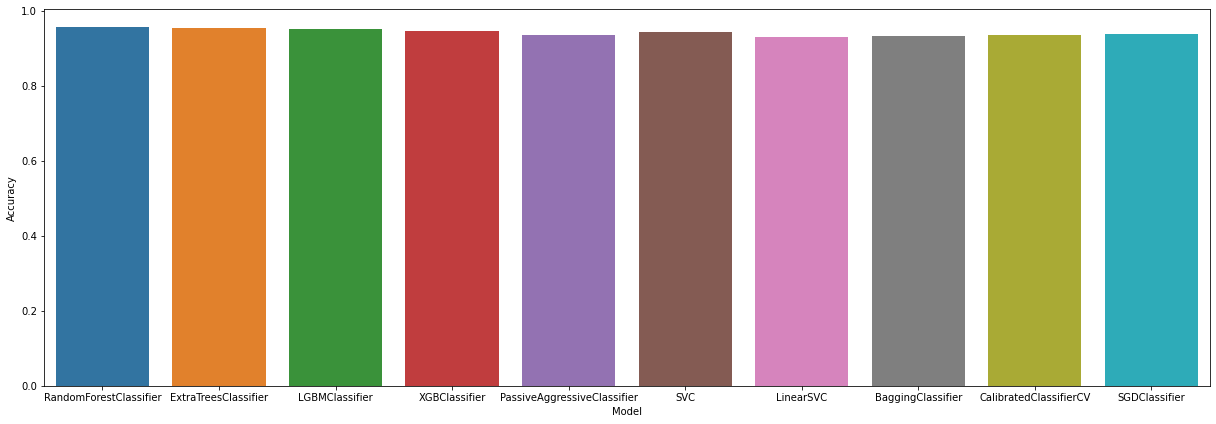

In [28]:
plt.figure(figsize=(17,6))
sns.barplot(x = models[0:10].index, y = models[0:10].Accuracy);
plt.tight_layout()

Binary Classification with all values

In [31]:
X = df.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass'])
y = df['bioactivity_binary_class']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [33]:
print(f'Null model accuracy: {round(max(y_test.mean(), 1 - y_test.mean()), 2)}')

Null model accuracy: 0.51


In [35]:
clf = Classification()

In [36]:
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [08:06<00:00, 16.78s/it]


In [37]:
models[0:8] #performs about the same as without intermediate values
       #considering the null value is 8% lower

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.86,0.86,0.86,0.86,10.10
RandomForestClassifier,0.86,0.86,0.86,0.86,8.66
SVC,0.86,0.86,0.86,0.86,98.60
LGBMClassifier,0.85,0.85,0.85,0.85,2.74
BaggingClassifier,0.85,0.85,0.85,0.85,11.94
XGBClassifier,0.85,0.85,0.85,0.85,10.46
NuSVC,0.85,0.85,0.85,0.85,123.35
DecisionTreeClassifier,0.84,0.84,0.84,0.84,2.31
ExtraTreeClassifier,0.83,0.83,0.83,0.83,0.76


Multiclass Classification with all values

In [50]:
df['bioactivity_multiclass'].replace(to_replace = 'inactive',
                                    value = 0, inplace=True)

df['bioactivity_multiclass'].replace(to_replace = 'intermediate',
                                    value = 1, inplace=True)

df['bioactivity_multiclass'].replace(to_replace = 'active',
                                    value = 2, inplace=True)

In [51]:
X = df.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass'])
y = df['bioactivity_multiclass']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [53]:
clf = Classification()

In [54]:
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [14:04<00:00, 29.14s/it]


In [56]:
models[0:5] #would need to adjust the classes and create separation

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.78,0.78,None,0.78,10.97
RandomForestClassifier,0.78,0.78,None,0.78,9.54
SVC,0.78,0.78,None,0.78,134.72
LGBMClassifier,0.77,0.77,None,0.77,5.89
NuSVC,0.77,0.77,None,0.76,164.16


# Regression Search

Regression predicting standard value with no intermediate values

In [64]:
X = df_small.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass'])
y = df_small['standard_value']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [70]:
null_y = np.full_like(y_train, y.mean())
print(f'Null y MSE: {mean_squared_error(y_train, null_y)}'')

66680455385.025826

In [71]:
rgr = Regression()

In [72]:
models, predictions = rgr.fit(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [18:23<00:00, 26.27s/it]


In [24]:
models[0:8]

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreeRegressor,-1.32,0.77,110406.47,3.83
KNeighborsRegressor,-1.84,0.71,122219.33,45.31
LGBMRegressor,-1.95,0.70,124479.78,2.81
GradientBoostingRegressor,-1.98,0.70,125171.52,19.73
HistGradientBoostingRegressor,-2.00,0.70,125603.53,35.54
ExtraTreesRegressor,-2.36,0.66,132944.09,328.55
RandomForestRegressor,-2.44,0.65,134402.08,256.70
LassoCV,-2.76,0.62,140567.89,284.87


Regression search predicting standard value with all values

In [29]:
X = df.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass'])
y = df['standard_value']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [31]:
null_y = np.full_like(y_train, y.mean())
print(f'Null y MSE: {mean_squared_error(y_train, null_y)}')

Null y MSE: 79338994929.76335


In [32]:
rgr = Regression()

In [33]:
models, predictions = rgr.fit(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [15:50<00:00, 22.64s/it]


In [36]:
len(models)

40

In [34]:
models.sort_values('R-Squared', ascending = False)[0:15]

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
HistGradientBoostingRegressor,1.21,0.80,126459.44,27.45
LGBMRegressor,1.21,0.79,127250.96,1.11
RandomForestRegressor,1.21,0.79,127324.58,107.45
BaggingRegressor,1.22,0.79,129528.08,11.43
AdaBoostRegressor,1.23,0.78,132420.18,13.12
KNeighborsRegressor,1.24,0.76,136648.91,10.93
ExtraTreesRegressor,1.24,0.76,137577.45,133.04
GradientBoostingRegressor,1.27,0.74,143829.16,8.40
LassoLars,1.34,0.67,161266.37,1.83


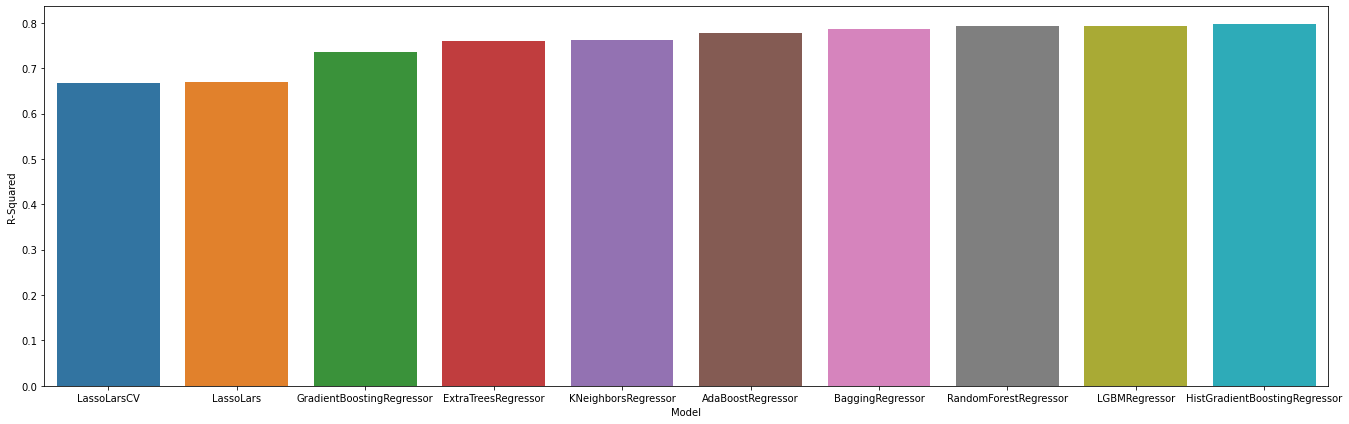

In [41]:
plt.figure(figsize=(19,6))
sns.barplot(x = models[30:40].index, y = models[30:40]['R-Squared']);
plt.tight_layout()

Regression predicting standard value with all values for comparison to search

In [91]:
X = df.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass'])
y = df['standard_value']

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [93]:
null_y = np.full_like(y_train, y.mean())
print(f'Null y MSE: {mean_squared_error(y_train, null_y)}')

Null y MSE: 41189386156.6015


In [94]:
rfr = RandomForestRegressor()

In [95]:
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [96]:
y_pred = rfr.predict(X_test)

In [43]:
def regression_eval(y_test, y_pred):
    print(f'MSE = {np.round(mean_squared_error(y_test, y_pred), 3)}')
    print(f'RMSE = {np.round(mean_squared_error(y_test, y_pred, squared = False), 3)}')
    print(f'MAE = {np.round(mean_absolute_error(y_test, y_pred), 3)}')
    print(f'r^2  = {np.round(r2_score(y_test, y_pred), 3)}')

In [98]:
regression_eval(y_test, y_pred)

MSE = 10723083509.396
RMSE = 103552.323
MAE = 22066.858
r^2  = 0.812


Standardizing target with log value of y

In [199]:
X = df.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass'])
y = df['standard_value']

In [200]:
y_std = y.map(lambda x: -np.log10(x * (10**-9)))

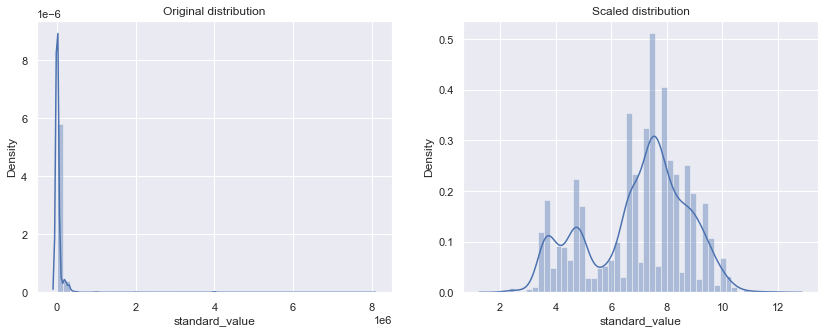

In [201]:
sns.set(style = 'darkgrid', context = 'notebook')
fig, ax = plt.subplots(1, 2, figsize = (14,5))
sns.distplot(df.standard_value, ax = ax[0]).set_title('Original distribution'); 
sns.distplot(y_std, ax = ax[1]).set_title('Scaled distribution');

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, y_std)

In [203]:
null_y = np.full_like(y_train, y_std.mean())
print(f'Null y MSE: {mean_squared_error(y_train, null_y)}')

Null y MSE: 3.0825849129775054


In [204]:
rfr = RandomForestRegressor()

In [205]:
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [206]:
y_pred = rfr.predict(X_test)

In [207]:
regression_eval(y_test, y_pred)

MSE = 0.884
RMSE = 0.94
MAE = 0.65
r^2  = 0.715


Regression with all values and variance threshold

In [ ]:
#faster and slightly better results, but not sure if it will work with feature extraction

In [178]:
X = df.drop(columns = ['canonical_smiles','standard_value',
                             'bioactivity_binary','bioactivity_binary_class',
                             'bioactivity_multiclass'])
y = df['standard_value']

In [169]:
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)
X.shape

(9128, 39)

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [180]:
null_y = np.full_like(y_train, y.mean())
print(f'Null y MSE: {mean_squared_error(y_train, null_y)}')

Null y MSE: 45136956530.517525


In [181]:
rfr = RandomForestRegressor()

In [182]:
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [183]:
y_pred = rfr.predict(X_test)

In [184]:
def regression_eval(y_test, y_pred):
    print(f'MSE = {np.round(mean_squared_error(y_test, y_pred), 3)}')
    print(f'RMSE = {np.round(mean_squared_error(y_test, y_pred, squared = False), 3)}')
    print(f'MAE = {np.round(mean_absolute_error(y_test, y_pred), 3)}')
    print(f'r^2  = {np.round(r2_score(y_test, y_pred), 3)}')

In [185]:
regression_eval(y_test, y_pred)

MSE = 10646541543.079
RMSE = 103182.08
MAE = 22282.526
r^2  = 0.765
